## <center>Global Biomass Estimation Using S2 and GEDI</center>
### <center>Extreme Gradient Boosting (XGB)</center>
**<center>This ipynb notebook was created by Oliver Hegi</center>**

This notebook contains the code for a Extreme Gradient Boosting (XGB). The predictors are Sentinel-2 images and the target is a set of GEDI biomass estimations.

#### Step 1 – Load the required packages

In [1]:
%%capture --no-display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Step 2 – Load the input and target data.
The data can be found in the folder /DATA

In [2]:
directory = 'DATA/'
Y = np.array(pd.read_csv(f'{directory}l_GEDI.csv', index_col=0)['0']) # of shape (10000,)
X = np.load(f'{directory}l_S2.npy', allow_pickle=True) # of shape (10000, 111, 111, 3) where each image is 111 pixels tall and 111 pixels wide and has three layers for RGB

#### STEP 3 – Standardize the data and flatten the images

In [3]:
mean, std = X.mean(), X.std()
X = (X - mean)/std # Only the input data needs to be standardized
X = X.reshape(X.shape[0], -1) # Shape is now 10000, 36963

#### STEP 4 – Train/test split

In [4]:
np.random.seed(1)
x_iis, x_test, y_iis, y_test = train_test_split(X, Y, test_size=0.2) #in-sample vs test
x_trn, x_val, y_trn, y_val = train_test_split(x_iis, y_iis, test_size=0.2) #train vs validate is drawn from the in-sample data

#### STEP 5 – Set up XGB model

In [5]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 5, alpha = 10, n_estimators = 20)

#### STEP 6 – Run model

In [6]:
model.fit(x_trn,y_trn, verbose=1, early_stopping_rounds=5, eval_set=[(x_trn,y_trn), (x_val, y_val)], eval_metric='logloss')

[0]	validation_0-logloss:-1292.24597	validation_1-logloss:-1266.31299
[1]	validation_0-logloss:-1303.34937	validation_1-logloss:-1308.00476
[2]	validation_0-logloss:-1325.13940	validation_1-logloss:-1338.62561
[3]	validation_0-logloss:-1325.13940	validation_1-logloss:-1338.62561
[4]	validation_0-logloss:-1325.13940	validation_1-logloss:-1338.62561
[5]	validation_0-logloss:-1325.13940	validation_1-logloss:-1338.62561
[6]	validation_0-logloss:-1325.13940	validation_1-logloss:-1338.62561
[7]	validation_0-logloss:-1325.13940	validation_1-logloss:-1338.62561


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### STEP 7 – Plot history

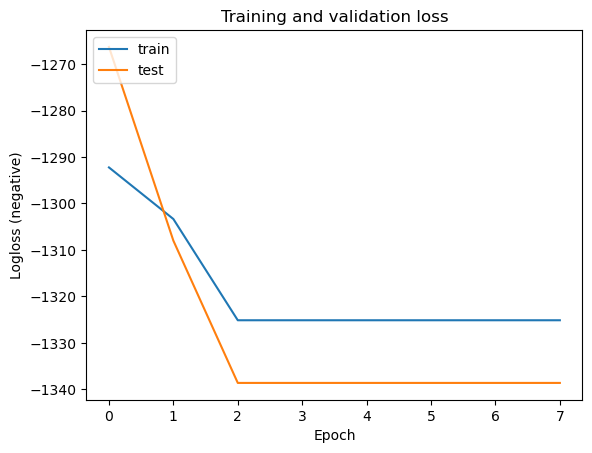

In [7]:
results = model.evals_result()
plt.plot(results['validation_0']['logloss'])
plt.plot(results['validation_1']['logloss'])
plt.title('Training and validation loss')
plt.ylabel('Logloss (negative)')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### STEP 8 – Out-of-sample test accuracy
Test the accuracy of the model on completelty untouched data

In [8]:
y_hat = model.predict(x_test) #x_test is untouched data
mean_squared_error(y_test, y_hat)

5629.4070083786755

#### STEP 9 – Plot predictions against actual values

[]

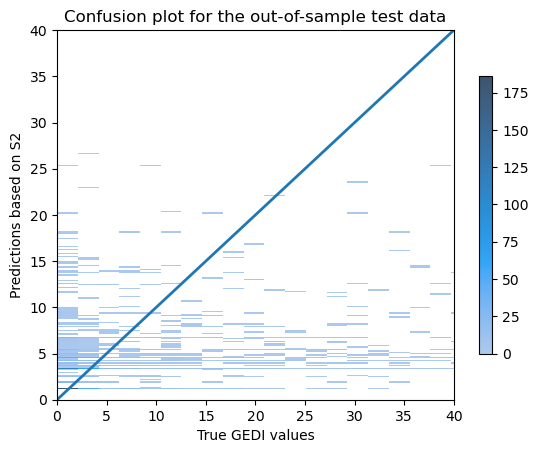

In [9]:
ax = sns.histplot(x=y_test, y=y_hat, bins=400, cbar=True, cbar_kws=dict(shrink=0.75))
ax.set_ylabel('Predictions based on S2')
ax.set_xlabel('True GEDI values')
ax.axline([0, 0], [1, 1], linewidth=2)
lim = 40
ax.set_xlim(0,lim)
ax.set_ylim(0,lim)
ax.set_title('Confusion plot for the out-of-sample test data')
ax.plot()